In [2]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph
import numpy as np

In [ ]:
# !pip install torch torch-geometric transformers sentence-transformers scikit-learn pandas numpy

# === Step 1: Load and Clean Data ===
df = pd.read_csv("Data_Breaches_K.csv")

# Drop rows with missing crucial values
df = df.dropna(subset=["Type of breach", "Sector", "Severity", "Year of Breach", "Records Exposed"])
df["Year of Breach"] = pd.to_numeric(df["Year of Breach"], errors='coerce')
df["Records Exposed"] = pd.to_numeric(df["Records Exposed"], errors='coerce')
df = df.dropna(subset=["Year of Breach", "Records Exposed"])

# === Step 2: Encode and Scale ===
le_sector = LabelEncoder()
df["Sector_encoded"] = le_sector.fit_transform(df["Sector"])

scaler = MinMaxScaler()
df["Year_scaled"] = scaler.fit_transform(df[["Year of Breach"]])
df["Records_scaled"] = scaler.fit_transform(df[["Records Exposed"]])

# === Step 3: BERT Embeddings for Breach Type ===
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
bert_embeddings = bert_model.encode(df["Type of breach"].tolist(), convert_to_tensor=True)
bert_embeddings = bert_embeddings.cpu().numpy()

# === Step 4: Combine All Features ===
feature_matrix = np.concatenate(
    [bert_embeddings,
     df[["Sector_encoded", "Year_scaled", "Records_scaled"]].values],
    axis=1
)
knn_graph = kneighbors_graph(feature_matrix, n_neighbors=8, mode='connectivity', include_self=False)
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)

# === Step 5: Prepare GCN Input ===
X = torch.tensor(feature_matrix, dtype=torch.float)
y = LabelEncoder().fit_transform(df["Severity"])
y = torch.tensor(y, dtype=torch.long)

train_mask, test_mask = train_test_split(np.arange(len(y)), test_size=0.2, stratify=y, random_state=42)
train_mask_t = torch.zeros(len(y), dtype=torch.bool)
test_mask_t = torch.zeros(len(y), dtype=torch.bool)
train_mask_t[train_mask] = True
test_mask_t[test_mask] = True

data = Data(x=X, edge_index=edge_index, y=y)
data.train_mask, data.test_mask = train_mask_t, test_mask_t

# === Step 6 (GAT Version): Define Enhanced GAT ===

class EnhancedGAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, heads=4):
        super(EnhancedGAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.4)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, dropout=0.4)
        self.gat3 = GATConv(hidden_dim * heads, num_classes, heads=1, concat=False, dropout=0.4)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.residual = torch.nn.Linear(input_dim, num_classes)  # Residual shortcut

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = F.elu(self.gat1(x, edge_index))
        h = self.dropout(h)
        h = F.elu(self.gat2(h, edge_index))
        h = self.dropout(h)
        out = self.gat3(h, edge_index)
        return F.log_softmax(out + self.residual(x), dim=1)

# === Step 7: Train GAT ===
model = EnhancedGAT(
    input_dim=data.num_features,
    hidden_dim=128,
    num_classes=len(torch.unique(data.y)),
    heads=4
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

losses = [] 

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())  # 👈 Track each epoch’s loss
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# === Step 8: Evaluate ===
model.eval()
_, pred = model(data).max(dim=1)
test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
test_acc = test_correct / data.test_mask.sum().item()
print(f"\n✅ Final Enhanced GAT Accuracy: {test_acc:.3f}\n")

# === Step 9: Classification Report ===
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Low", "Medium", "High"]))



c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

Epoch 0, Loss: 0.9530
Epoch 20, Loss: 0.5726
Epoch 40, Loss: 0.5283
Epoch 60, Loss: 0.5189
Epoch 80, Loss: 0.4893
Epoch 100, Loss: 0.4651
Epoch 120, Loss: 0.4260
Epoch 140, Loss: 0.3897
Epoch 160, Loss: 0.3637
Epoch 180, Loss: 0.3344

✅ Final Enhanced GAT Accuracy: 0.917

📊 Classification Report:
              precision    recall  f1-score   support

         Low       1.00      0.90      0.95       575
      Medium       0.94      0.95      0.94        80
        High       0.72      0.97      0.83       169

    accuracy                           0.92       824
   macro avg       0.89      0.94      0.91       824
weighted avg       0.94      0.92      0.92       824



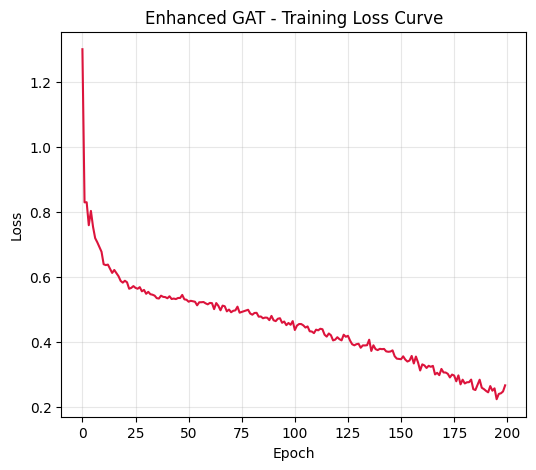

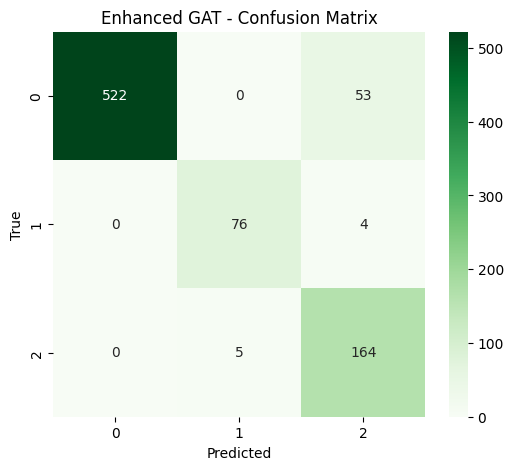

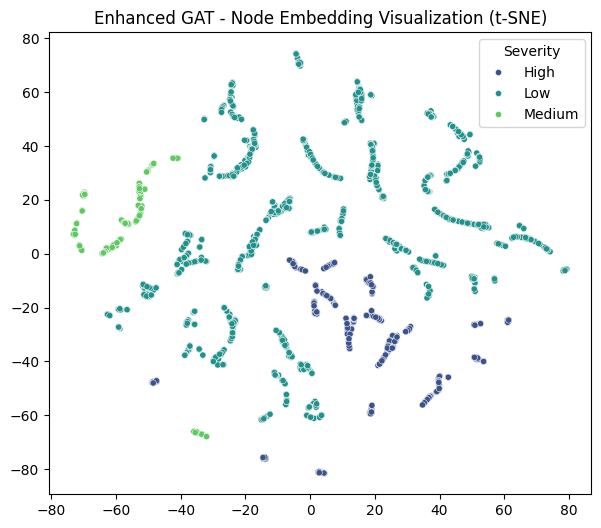

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

# --- Loss Curve ---
plt.figure(figsize=(6,5))
plt.plot(losses, color='crimson')
plt.title("Enhanced GAT - Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()

# --- Confusion Matrix ---
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens')
plt.title("Enhanced GAT - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- t-SNE Visualization of Node Embeddings ---
model.eval()
with torch.no_grad():
    embeddings = model(data).cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(embeddings)

labels = ["Low", "Medium", "High"]
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    hue=[labels[i] for i in data.y.cpu().numpy()],
    palette='viridis',
    s=20
)
plt.title("Enhanced GAT - Node Embedding Visualization (t-SNE)")
plt.legend(title="Severity")
plt.show()


In [1]:
# --- Install dependencies ---
# !pip install torch torch-geometric transformers sentence-transformers scikit-learn pandas numpy

import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report

# === Step 1: Load and Clean Data ===
df = pd.read_csv("Data_Breaches_K.csv")
df = df.dropna(subset=["Company", "Type of breach", "Sector", "Severity", "Year of Breach", "Records Exposed"])
df["Year of Breach"] = pd.to_numeric(df["Year of Breach"], errors="coerce")
df["Records Exposed"] = pd.to_numeric(df["Records Exposed"], errors="coerce")
df = df.dropna(subset=["Year of Breach", "Records Exposed"])

# === Step 2: Company-Level Aggregation ===
agg_funcs = {
    "Records Exposed": ["mean", "max", "sum", "count"],
    "Year of Breach": ["min", "max"],
}
company_df = df.groupby("Company").agg(agg_funcs)
company_df.columns = ["_".join(col) for col in company_df.columns]

# Most frequent sector per company
sector_map = df.groupby("Company")["Sector"].agg(lambda x: x.value_counts().index[0])
company_df["Sector"] = sector_map

# Encode sector
le_sector = LabelEncoder()
company_df["Sector_encoded"] = le_sector.fit_transform(company_df["Sector"])

# Target: High risk if company ever had a high-severity breach
company_df["HighRisk"] = df.groupby("Company")["Severity"].apply(lambda x: 1 if "High" in x.values else 0)

# === Step 3: BERT Embeddings for Breach Types ===
os.environ["USE_TF"] = "0"
os.environ["USE_TORCH"] = "1"
os.environ["TRANSFORMERS_NO_TF_WARNING"] = "1"

bert_model = SentenceTransformer("all-MiniLM-L6-v2")
type_embeddings = df.groupby("Company")["Type of breach"].apply(
    lambda x: np.mean(bert_model.encode(x.tolist(), convert_to_numpy=True), axis=0)
)
company_df = company_df.merge(type_embeddings.rename("BERT_emb"), left_index=True, right_index=True)

# === Step 4: Combine Features ===
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(company_df[[
    "Records Exposed_mean", "Records Exposed_max", "Records Exposed_sum",
    "Records Exposed_count", "Year of Breach_min", "Year of Breach_max", "Sector_encoded"
]])
embeddings = np.stack(company_df["BERT_emb"].values)
X = np.concatenate([embeddings, scaled_features], axis=1)

# === Step 5: Graph Construction ===
knn_graph = kneighbors_graph(X, n_neighbors=5, mode="connectivity", include_self=False)
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)

# === Step 6: PyG Data ===
X_tensor = torch.tensor(X, dtype=torch.float)
y = torch.tensor(company_df["HighRisk"].values, dtype=torch.long)

train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, stratify=y, random_state=42)
train_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

data = Data(x=X_tensor, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)

# === Step 7: Define GAT Model ===
class CompanyRiskGAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, heads=4):
        super(CompanyRiskGAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.4)
        self.gat2 = GATConv(hidden_dim*heads, hidden_dim, heads=heads, dropout=0.4)
        self.gat3 = GATConv(hidden_dim*heads, num_classes, heads=1, concat=False, dropout=0.4)
        self.dropout = torch.nn.Dropout(0.5)
        self.residual = torch.nn.Linear(input_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = F.elu(self.gat1(x, edge_index))
        h = self.dropout(h)
        h = F.elu(self.gat2(h, edge_index))
        h = self.dropout(h)
        out = self.gat3(h, edge_index)
        return F.log_softmax(out + self.residual(x), dim=1)

# === Step 8: Train GAT ===
model = CompanyRiskGAT(input_dim=data.num_features, hidden_dim=128, num_classes=2, heads=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

for epoch in range(150):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# === Step 9: Evaluate ===
model.eval()
_, pred = model(data).max(dim=1)
test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
test_acc = test_correct / data.test_mask.sum().item()
print(f"\n✅ Final Company Risk GAT Accuracy: {test_acc:.3f}\n")

y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Low Risk", "High Risk"]))


c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_core

Epoch 0, Loss: 0.7076
Epoch 20, Loss: 0.4805
Epoch 40, Loss: 0.4595
Epoch 60, Loss: 0.4670
Epoch 80, Loss: 0.4560
Epoch 100, Loss: 0.4524
Epoch 120, Loss: 0.4529
Epoch 140, Loss: 0.4517

✅ Final Company Risk GAT Accuracy: 0.795

📊 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.93      0.33      0.49       228
   High Risk       0.78      0.99      0.87       548

    accuracy                           0.80       776
   macro avg       0.85      0.66      0.68       776
weighted avg       0.82      0.80      0.76       776



In [8]:
company_name = "MailMyPrescriptions.com"
idx = company_df.index.get_loc(company_name)
model.eval()
prob = torch.exp(model(data))[idx, 1].item()
print(f"🏢 {company_name} | Predicted Future High-Risk Probability: {prob:.2f}")

🏢 MailMyPrescriptions.com | Predicted Future High-Risk Probability: 0.75
